# Multi Author Writing Style Analysis
by: Noah Syrkis

In [235]:
from utils import get_data
import torch
from torch import nn, optim
from collections import Counter, defaultdict
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import warnings; warnings.simplefilter('ignore')
from labml import experiment, tracker

In [249]:
# constants
dataset_names = [f'pan23-multi-author-analysis-dataset{i}' for i in range(1, 4)]
PAD = '<PAD>'  # id 0
UNK = '<UNK>'  # id 1
PAD_ID = 0
UNK_ID = 1
batch_size = 32
block_size = 8

In [250]:
# read in data
one_train_data = get_data(dataset_names[0], 'train')
one_valid_data = get_data(dataset_names[0], 'validation')
two_train_data = get_data(dataset_names[1], 'train')
two_valid_data = get_data(dataset_names[1], 'validation')
three_train_data = get_data(dataset_names[2], 'train')
three_valid_data = get_data(dataset_names[2], 'validation')

100%|██████████| 900/900 [00:00<00:00, 1001.15it/s]


In [251]:
# functions
encode = lambda x, stoi: [stoi.get(w, UNK_ID) for w in x]
decode = lambda x, itos: ''.join([itos.get(i, UNK) for i in x])
flatten = lambda x: [i for j in x for i in j]

def make_word_vocab(dataset, min_count=50):
    # make a vocabulary from the training set
    vocab = Counter(flatten(flatten(dataset['text'])))
    vocab = [w for w, c in vocab.most_common() if c > min_count] + ['\n', ' '] + list('abcdefghijklmnopqrstuvwxyz') + list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    vocab = [PAD, UNK] + sorted(list(set(vocab)))
    # return UNK if word is not in vocab
    stoi = defaultdict(lambda: 1, {w: i for i, w in enumerate(vocab)})
    itos = {i: w for i, w in enumerate(vocab)}
    return stoi, itos


def make_char_vocab(dataset, min_count=50):
    # make a vocabulary from the training set
    vocab = Counter(flatten(flatten(dataset['text'])))
    vocab = [w for w, c in vocab.most_common() if c > min_count] + ['\n', ' '] + list('abcdefghijklmnopqrstuvwxyz') + list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    vocab = [PAD, UNK] + sorted(list(set(vocab)))
    # return UNK if word is not in vocab
    stoi = defaultdict(lambda: 1, {w: i for i, w in enumerate(vocab)})
    itos = {i: w for i, w in enumerate(vocab)}
    return stoi, itos

In [252]:
ctoi, itoc = make_char_vocab(one_train_data)  # character vocab
wtoi, itow = make_word_vocab(one_train_data)  # word vocab


## Language Model

In [253]:
# encode the data and make one flat long list of all the text
one_train_text = encode("".join(flatten(flatten(one_train_data['text']))), ctoi)
one_valid_text = encode("".join(flatten(flatten(one_valid_data['text']))), ctoi)

In [298]:
def get_batch(data, block_size, batch_size):
    # data is flat list of ids
    idxs = np.random.randint(0, len(data) - block_size - 1, batch_size)
    xs = [data[i:i + block_size] for i in idxs]
    pad = lambda i: [[PAD_ID] * (block_size - j - 1) + xs[i][:j+1] for j in range(block_size)]
    xs = flatten([pad(i) for i in range(batch_size)])
    xs = torch.tensor(xs).long()  # (batch_size, block_size)
    ys = flatten([data[i + 1:i + block_size + 1] for i in idxs])
    ys = torch.tensor(ys).long()  # (batch_size, block_size)
    return xs, ys


@torch.no_grad()
def evaluate(model, train_data, val_data, block_size, batch_size, prev_losses=None):
    model.eval()
    losses = {}
    for split, data in [('train', train_data), ('valid', val_data)]:
        losses[split] = []
        for _ in range(10):
            xs, ys = get_batch(data, block_size, batch_size)
            _, loss = model(xs, ys)
            losses[split].append(loss.item())
        losses[split] = np.mean(losses[split])
    model.train()
    if prev_losses is not None and prev_losses['valid'] > losses['valid'] and prev_losses['train'] > losses['train']:
        torch.save(model.state_dict(), 'lm.pth')
    return losses


def train(model, train_data, valid_data, opt, conf):
    with experiment.record(name='lm', exp_conf=conf):
        for i in range(conf['n_iters']):
            xs, ys = get_batch(one_train_text, conf['block_size'], conf['batch_size'])
            _, loss = model(xs, ys)
            opt.zero_grad()
            loss.backward()
            opt.step()
            if i % (conf['n_iters'] // 50) == 0:
                losses = evaluate(model, train_data, valid_data, conf['block_size'], conf['batch_size'])
                tracker.save(i, {'train_loss': losses['train'], 'valid_loss': losses['valid']})


def load_model(model, path):
    model.load_state_dict(torch.load(path))
    return model

In [315]:
class Model(nn.Module):
    
    def __init__(self, vocab_size, hidden_dim, stoi, itos):
        super(Model, self).__init__()
        self.stoi = stoi
        self.itos = itos
        self.embed = nn.Embedding(vocab_size, vocab_size, padding_idx=PAD_ID)
        self.rnn = nn.GRU(vocab_size, hidden_dim, batch_first=True, dropout=0.1, num_layers=2)
        self.fcs = nn.Sequential(
            nn.Linear(hidden_dim, vocab_size),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(vocab_size, vocab_size),
        )


    def forward(self, idx, targets=None):
        logits = self.embed(idx)
        logits, _ = self.rnn(logits)
        logits = self.fcs(logits)
        logits = torch.sum(logits, dim=1)
        if targets is None:
            loss = None
        else:
            loss = nn.functional.cross_entropy(logits, targets)
        return logits, loss
    
    def generate(self, n_words, context, temp=0.5):
        self.eval()
        for _ in range(n_words):
            logits, _ = self.forward(context)
            logits = logits / temp
            probs = nn.functional.softmax(logits, dim=-1)
            word = torch.multinomial(probs, 1).item()
            context = torch.cat([context, torch.tensor([word]).long().view(1, 1)], dim=1)
        self.train()
        return decode(context.numpy().flatten().tolist(), self.itos)


In [318]:
conf = {'block_size': 8, 'batch_size': 16, 'hidden_dim': 128, 'n_iters': 10000}
m = Model(len(itoc), conf['hidden_dim'], ctoi, itoc)
opt = optim.Adam(m.parameters(), lr=1e-3, weight_decay=1e-5)
train(m, one_train_text, one_valid_text, opt, conf)

OMP: Warning #190: Forking a process while a parallel region is active is potentially unsafe.


In [314]:
context = torch.tensor([ctoi['\n']]).long().view(1, 1)
print(m.generate(100, context))


Merrlá4 one atterrrrrrryerlelytly conlllltltllylyyydyy rrrrrreiereeerlyy orrreeyoeoeeleere orreeerry


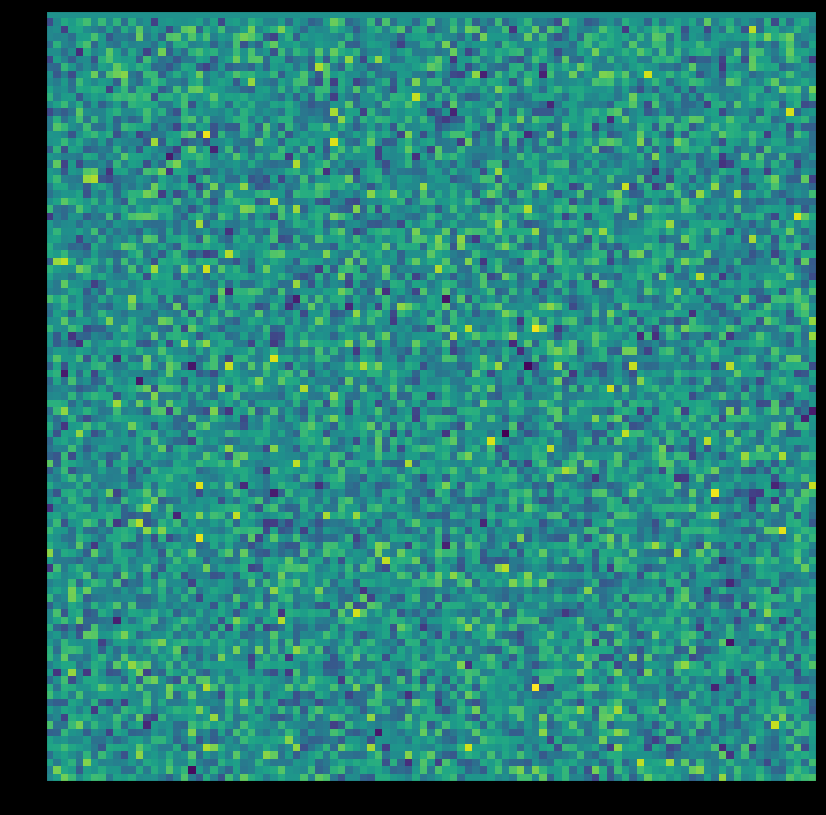

In [280]:
# set balck background
plt.rcParams['figure.facecolor'] = 'black'
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(list(m.parameters())[0].detach().numpy());